In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
model_basepath = "/vol/ideadata/ed52egek/pycharm/privatis_us/archive/DynamicISBest"
#synthetic_latent_path = "/vol/ideadata/at70emic/projects/TMI23/samples/lidm_vpred/checkpoint-380000/ddim_64_100k/latents"
#private_latents_output_path = "/vol/ideadata/ed52egek/dynamic/outputs"
DEBUG = False

training_latents_csv = "/vol/ideadata/at70emic/datasets/EchoNet-Dynamic/FileList.csv"
training_latents_basepath = "/vol/ideadata/at70emic/datasets/EchoNet-Dynamic/Videos"

In [2]:
import matplotlib.pyplot as plt
import os
from torch.utils import data
import torch
import pandas as pd
import numpy as np
import random
from PIL import Image
from einops import rearrange
import cv2

PHASE_TO_SPLIT = {"training": "TRAIN", "validation": "VAL", "testing": "TEST"}

def load_avi(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames


class SimaseUSVideoDataset(data.Dataset):
    def __init__(self, 
                 phase='training', 
                 transform=None,
                 latents_csv='./', 
                 training_latents_base_path="./", 
                 in_memory=True, 
                 generator_seed=None):
        self.phase = phase
        self.training_latents_base_path = training_latents_base_path

        self.in_memory = in_memory
        self.videos = []

        self.df = pd.read_csv(latents_csv)
        self.df = self.df[self.df["Split"] == PHASE_TO_SPLIT[self.phase]].reset_index(drop=True)

        self.transform = transform

        if generator_seed is None: 
            self.generator = np.random.default_rng() 
            #unseeded
        else:             
            self.generator_seed = generator_seed
            print(f"Set {self.phase} dataset seed to {self.generator_seed}")

        if self.in_memory: 
            self.load_videos()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        vid_a = self.get_vid(index)
        if self.transform is not None:
            vid_a = self.transform(vid_a)
        return vid_a

    def reset_generator(self): 
        self.generator = np.random.default_rng(self.generator_seed) 

    def load_videos(self): 
        self.videos = []
        print("Preloading videos")
        for i in range(len(self)):
            self.videos.append(self.get_vid(i, from_disk=True))

    def get_vid(self, index, from_disk=False): 
        if self.in_memory and not from_disk: 
            return self.videos[index]
        else: 
            file_name = self.df.iloc[index]["FileName"] + ".avi" if not self.df.iloc[index]["FileName"].endswith(".avi") else self.df.iloc[index]["FileName"]
            video_file_path = os.path.join(self.training_latents_base_path, file_name)
            video_frames = load_avi(video_file_path)
            video_frames = torch.tensor(np.stack(video_frames))
            video_frames = video_frames / 127.5 - 1 
            return rearrange(video_frames, "b h w c -> b c h w")


normalization =lambda x: (x  - x.min())/(x.max() - x.min()) * 2 - 1  # should be -1 to 1 due to way we trained the model
ds_train = SimaseUSVideoDataset(phase="training", transform=normalization, latents_csv=training_latents_csv, training_latents_base_path=training_latents_basepath, in_memory=False)
ds_synth = SimaseUSVideoDataset(phase="training", transform=normalization, latents_csv="/vol/ideadata/at70emic/projects/EchoNet-Synthetic/datasets/EchoNet-Synthetic/dynamic/FileList.csv", training_latents_base_path="/vol/ideadata/at70emic/projects/EchoNet-Synthetic/datasets/EchoNet-Synthetic/dynamic/Videos", in_memory=False)

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models


class SiameseNetwork(nn.Module):
    def __init__(self, network='ResNet-50', in_channels=3, n_features=128):
        super(SiameseNetwork, self).__init__()
        self.network = network
        self.in_channels = in_channels
        self.n_features = n_features

        if self.network == 'ResNet-50':
            # Model: Use ResNet-50 architecture
            self.model = models.resnet50(pretrained=True)
            # Adjust the input layer: either 1 or 3 input channels
            if self.in_channels == 1:
                self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            if self.in_channels == 4: 
                self.model.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            elif self.in_channels == 3:
                pass
            else:
                raise Exception(
                    'Invalid argument: ' + self.in_channels + '\nChoose either in_channels=1 or in_channels=3')
            # Adjust the ResNet classification layer to produce feature vectors of a specific size
            self.model.fc = nn.Linear(in_features=2048, out_features=self.n_features, bias=True)

        else:
            raise Exception('Invalid argument: ' + self.network +
                            '\nChoose ResNet-50! Other architectures are not yet implemented in this framework.')

        self.fc_end = nn.Linear(self.n_features, 1)

    def forward_once(self, x):

        # Forward function for one branch to get the n_features-dim feature vector before merging
        output = self.model(x)
        output = torch.sigmoid(output)
        return output

    def forward(self, input1, input2):

        # Forward
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # Compute the absolute difference between the n_features-dim feature vectors and pass it to the last FC-Layer
        difference = torch.abs(output1 - output2)
        output = self.fc_end(difference)

        return output

import json
with open(os.path.join(model_basepath, "config.json")) as config:
    config = config.read()
# parse config
config = json.loads(config)
net = SiameseNetwork(network=config['siamese_architecture'], in_channels=config['n_channels'], n_features=config['n_features'])
best_name = [x for x in os.listdir(model_basepath) if x.endswith("best_network.pth")][0]
net.load_state_dict(torch.load(os.path.join(model_basepath, best_name)))
net = net.cuda()
    

/vol/ideadata/ed52egek/conda/latecho/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/ideadata/ed52egek/conda/latecho/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/vol/ideadata/ed52egek/conda/latecho/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Number of videos to process for synthetic and real videos
num_videos = 1000
synth_cnt = 0
real_cnt = 0
video_length = 150
bs = 256

ref_frame = 0  # -1 is synthetic frame

real_cor_timeseries = []
# Plotting synthetic videos
j = 0
while real_cnt < num_videos:
    latent_real_video = ds_train[j]
    j+=1
    if len(latent_real_video) < video_length:
        continue

    latent_real_video = latent_real_video[:video_length]
    latents_real = []
    with torch.no_grad():
        for i in np.arange(0, len(latent_real_video), bs):
            batch = latent_real_video[i:i+bs].cuda()
            latents_real.append(net.forward_once(batch))
    latents_real = torch.cat(latents_real)
    train_val_corr_orig = torch.corrcoef(torch.cat([latents_real])).cpu()
    train_val_corr_frame = np.delete(train_val_corr_orig[ref_frame], ref_frame)
    real_cor_timeseries.append(train_val_corr_frame)
    real_cnt += 1

synth_cor_timeseries = []
# Plotting synthetic videos
j = 0
while synth_cnt < num_videos:
    latent_syn_video = ds_synth[j]
    j+=1
    if len(latent_syn_video) < video_length:
        continue

    latent_syn_video = latent_syn_video[:video_length]
    latents_synth = []
    with torch.no_grad():
        for i in np.arange(0, len(latent_syn_video), bs):
            batch = latent_syn_video[i:i+bs].cuda()
            latents_synth.append(net.forward_once(batch))
    latents_synth = torch.cat(latents_synth)
    train_val_corr_full = torch.corrcoef(torch.cat([latents_synth])).cpu()
    train_val_corr_frame = np.delete(train_val_corr_full[ref_frame], ref_frame)
    synth_cor_timeseries.append(train_val_corr_frame)
    synth_cnt += 1


# Confusion Matrices 

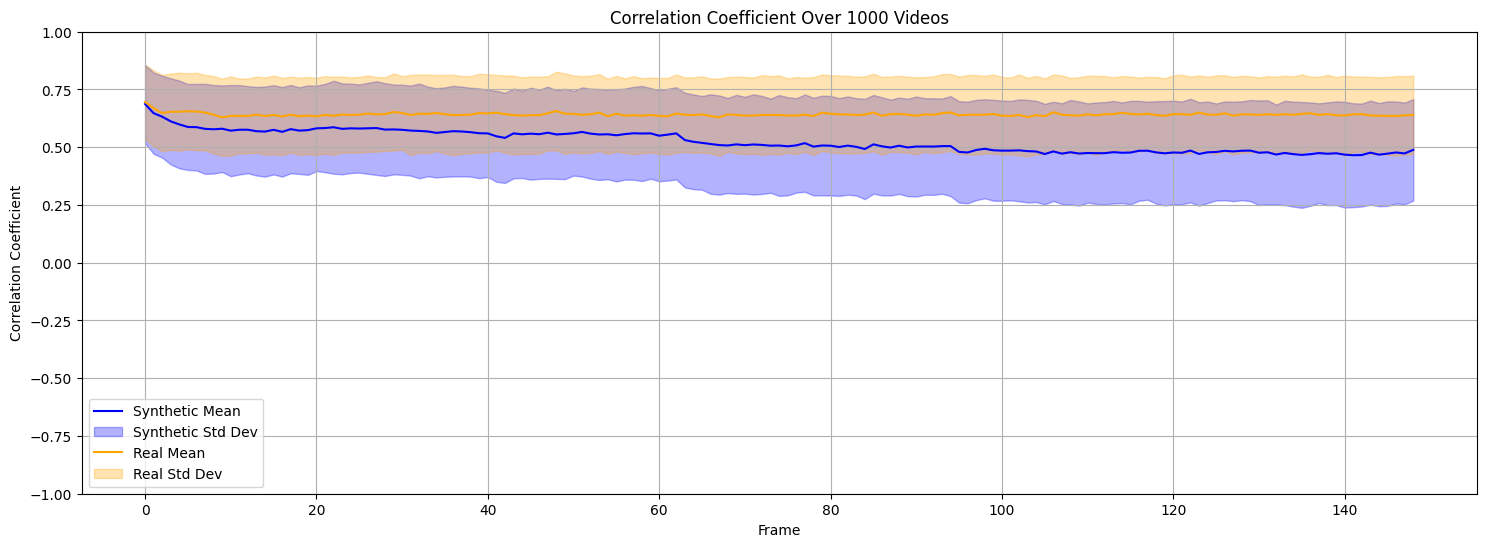

In [5]:
synth_cor_timeseries = np.array(synth_cor_timeseries)
real_cor_timeseries = np.array(real_cor_timeseries)

# Compute mean and standard deviation
synth_mean = np.mean(synth_cor_timeseries, axis=0)
synth_std = np.std(synth_cor_timeseries, axis=0)

real_mean = np.mean(real_cor_timeseries, axis=0)
real_std = np.std(real_cor_timeseries, axis=0)

# Time axis (assuming all time series are of the same length)
time_axis = np.arange(real_mean.shape[0])

# Create the plot
fig, ax = plt.subplots(figsize=(18, 6))
# Plot the synthetic data
ax.plot(time_axis, synth_mean, label='Synthetic Mean', color='blue')
ax.fill_between(time_axis, synth_mean - synth_std, synth_mean + synth_std, color='blue', alpha=0.3, label='Synthetic Std Dev')

# Plot the real data
ax.plot(time_axis, real_mean, label='Real Mean', color='orange')
ax.fill_between(time_axis, real_mean - real_std, real_mean + real_std, color='orange', alpha=0.3, label='Real Std Dev')

# Customize the plot
ax.set_title('Correlation Coefficient Over 1000 Videos')
ax.set_ylabel('Correlation Coefficient')
ax.set_xlabel('Frame')
ax.set_ylim(-1, 1)
ax.grid(True)
ax.legend()
plt.savefig("correlation_coeff_realvssyn_dynamic.png", dpi=600)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Number of videos to process for synthetic and real videos
num_videos = 1000
synth_cnt = 0
real_cnt = 0
diff_cnt = 0
video_length = 150
bs = 256

ref_frame = 0  # -1 is synthetic frame

real_cor_timeseries = []
# Plotting synthetic videos
j = 0
while real_cnt < num_videos:
    latent_real_video = ds_train[j]
    j+=1
    if len(latent_real_video) < video_length:
        continue

    latent_real_video = latent_real_video[:video_length]
    latents_real = []
    with torch.no_grad():
        for i in np.arange(0, len(latent_real_video), bs):
            batch = latent_real_video[i:i+bs].cuda()
            latents_real.append(net.forward_once(batch))
    latents_real = torch.cat(latents_real)
    train_val_corr_orig = torch.corrcoef(torch.cat([latents_real])).cpu()
    train_val_corr_frame = np.delete(train_val_corr_orig[ref_frame], ref_frame)
    real_cor_timeseries.append(train_val_corr_frame)
    real_cnt += 1

synth_cor_timeseries = []
# Plotting synthetic videos
j = 0
while synth_cnt < num_videos:
    latent_syn_video = ds_synth[j]
    j+=1
    if len(latent_syn_video) < video_length:
        continue

    latent_syn_video = latent_syn_video[:video_length]
    latents_synth = []
    with torch.no_grad():
        for i in np.arange(0, len(latent_syn_video), bs):
            batch = latent_syn_video[i:i+bs].cuda()
            latents_synth.append(net.forward_once(batch))
    latents_synth = torch.cat(latents_synth)
    train_val_corr_full = torch.corrcoef(torch.cat([latents_synth])).cpu()
    train_val_corr_frame = np.delete(train_val_corr_full[ref_frame], ref_frame)
    synth_cor_timeseries.append(train_val_corr_frame)
    synth_cnt += 1

synth_cor_timeseries_diff = []
# Plotting synthetic videos
j = 0
while diff_cnt < num_videos:
    latent_syn_video = ds_train[j]
    j+=1
    if len(latent_syn_video) < video_length:
        continue
    latent_syn_ref = ds_train[(j+1)%len(ds_train)]
    latent_syn_video = latent_syn_video[:video_length]
    latent_syn_video[ref_frame] = latent_syn_ref[ref_frame] 
    latents_synth_diff = []
    with torch.no_grad():
        for i in np.arange(0, len(latent_syn_video), bs):
            batch = latent_syn_video[i:i+bs].cuda()
            latents_synth_diff.append(net.forward_once(batch))
    latents_synth_diff = torch.cat(latents_synth_diff)
    train_val_corr_full_diff = torch.corrcoef(torch.cat([latents_synth_diff])).cpu()
    train_val_corr_frame_diff = np.delete(train_val_corr_full_diff[ref_frame], ref_frame)
    synth_cor_timeseries_diff.append(train_val_corr_frame_diff)
    diff_cnt += 1

synth_cor_timeseries = np.array(synth_cor_timeseries)
real_cor_timeseries = np.array(real_cor_timeseries)
synth_cor_timeseries_diff = np.array(synth_cor_timeseries_diff)

# Compute mean and standard deviation
synth_mean = np.mean(synth_cor_timeseries, axis=0)
synth_std = np.std(synth_cor_timeseries, axis=0)

real_mean = np.mean(real_cor_timeseries, axis=0)
real_std = np.std(real_cor_timeseries, axis=0)

diff_mean = np.mean(synth_cor_timeseries_diff, axis=0)
diff_std = np.std(synth_cor_timeseries_diff, axis=0)



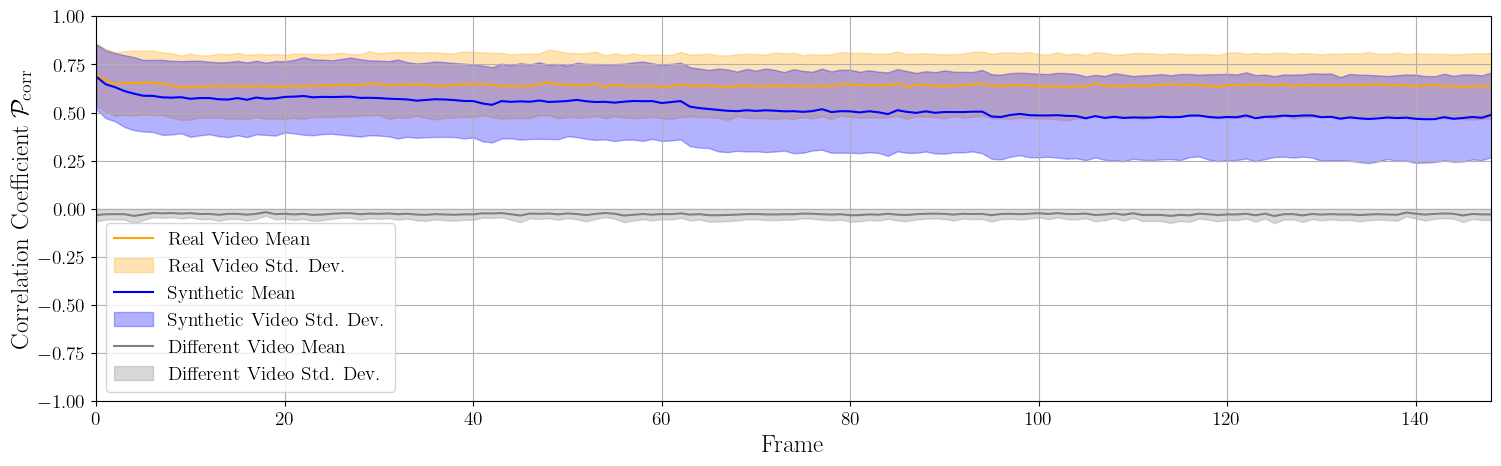

In [26]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

# Time axis (assuming all time series are of the same length)
time_axis = np.arange(real_mean.shape[0])

# Create the plot
fig, ax = plt.subplots(figsize=(18, 5))
# Plot the real data
ax.plot(time_axis, real_mean, label=r'Real Video Mean', color='orange')
ax.fill_between(time_axis, real_mean - real_std, real_mean + real_std, color='orange', alpha=0.3, label=r'Real Video Std. Dev.')

# Plot the synthetic data
ax.plot(time_axis, synth_mean, label=r'Synthetic Mean', color='blue')
ax.fill_between(time_axis, synth_mean - synth_std, synth_mean + synth_std, color='blue', alpha=0.3, label=r'Synthetic Video Std. Dev.')

# Plot diff data
ax.plot(time_axis, diff_mean, label=r'Different Video Mean', color='grey')
ax.fill_between(time_axis, diff_mean - diff_mean, diff_mean + diff_mean, color='grey', alpha=0.3, label=r'Different Video Std. Dev.')

# Customize the plot
#ax.set_title('Mean Correlation Coefficient')
ax.set_ylabel(r'Correlation Coefficient $\mathcal{P}_{\text{corr}}$', fontsize=18)
ax.set_xlabel('Frame', fontsize=18)
ax.set_ylim(-1, 1)
ax.set_xlim(0, video_length -2)
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
plt.savefig("correlation_coeff_realvssynvsdiff_dynamic.pdf", dpi=600)
plt.show()